In [1]:
%load_ext aiida

In [2]:
%aiida

Loaded AiiDA DB environment - profile name: c2sm.

In [11]:
from aiida import orm, engine
from aiida_c2sm import spice
import pendulum
import tabulate
import typing_extensions
import dataclasses
import pathlib

In [4]:
builder = spice.prepare.prep_workflow.PreparationWorkflow.get_builder()
builder.computer_uuid = orm.Str(orm.load_computer("Daint").uuid)
builder.gcm_dir = spice.data.get_gcm_data()
builder.gcm_relpath_template = "year{current_date.year:04}/ERAINT_{current_date.year:04}_{current_date.month:02}.tar"
builder.iso_current_date = orm.Str("1979-01-01T00:00:00")

In [5]:
#engine.run(builder)

In [6]:
n = orm.load_node(3188)

In [7]:
print(
    tabulate.tabulate(
        [(c.pk, c.label, c.ctime, c.mtime) for c in n.called],
        tablefmt="plain",
    )
)

3190  prep:remarkable-raptor@1979-01-01T00:00:00+00:00  2023-08-17 10:30:18.375765+02:00  2023-08-17 10:41:13.020516+02:00
3195  conv:remarkable-raptor@1979-01-01T00:00:00+00:00  2023-08-17 10:41:13.185073+02:00  2023-08-17 10:47:12.987311+02:00
3206  icon:remarkable-raptor@1979-01-01T00:00:00+00:00  2023-08-17 10:47:13.282575+02:00  2023-08-17 11:01:34.379999+02:00
3208  prep:remarkable-raptor@1979-02-01T00:00:00+00:00  2023-08-17 10:47:14.077151+02:00  2023-08-17 10:57:28.156386+02:00
3222  conv:remarkable-raptor@1979-02-01T00:00:00+00:00  2023-08-17 10:57:34.973840+02:00  2023-08-17 11:02:16.118546+02:00
3236  icon:remarkable-raptor@1979-02-01T00:00:00+00:00  2023-08-17 11:02:16.538666+02:00  2023-08-17 11:02:22.937959+02:00


In [8]:
from aiida.tools import visualization as aviz
from aiida import common

In [9]:
def my_sublabels(node: orm.Node) -> str:
    if node.class_node_type == 'data.core.str.Str.':
        lines = node.value.splitlines()
        if len(lines) < 5:
            return node.value
        else:
            return "\n".join([*lines[:3], "...", lines[-1]])
    return aviz.default_node_sublabels(node)


def my_link_styles(link_pair: orm.LinkPair, add_label: bool, add_type: bool) -> dict:
    style = aviz.default_link_styles(link_pair, add_label, add_type)
    if link_pair.link_type in [common.LinkType.INPUT_CALC, common.LinkType.CREATE] and link_pair.link_label in ["gcm_data", "gcm_prepared", "converted", "gcm_converted", "restart_file_dir", "restart_file_name"]:
        style["color"] = "red"
        style["penwidth"] = 4
    return style

In [34]:
def full_graph(node_nr: int, annotate_links: str, **kwargs) -> aviz.Graph:
    g = aviz.Graph(graph_attr={"size": "16,16"}, node_sublabel_fn=my_sublabels, link_style_fn=my_link_styles, **kwargs)
    g.recurse_ancestors(orm.load_node(node_nr), annotate_links=annotate_links)
    g.recurse_descendants(orm.load_node(node_nr), annotate_links=annotate_links)
    return g


def local_graph(node_nr: int, annotate_links: str, **kwargs) -> aviz.Graph:
    graph = aviz.Graph(graph_attr={"size": "16,16"}, node_sublabel_fn=my_sublabels, link_style_fn=my_link_styles, **kwargs)
    graph.add_incoming(load_node(node_nr), annotate_links=annotate_links)
    graph.add_outgoing(load_node(node_nr), annotate_links=annotate_links)
    return graph


def store_graph(graph: aviz.Graph, dir: pathlib.Path, base_name: str) -> None:
    graph.graphviz.render(dir / base_name)
    graph.graphviz.save(dir / (base_name + ".dot"))


GRAPHDIR = pathlib.Path("/Users/ricoh/Documents/aiida-c2sm")

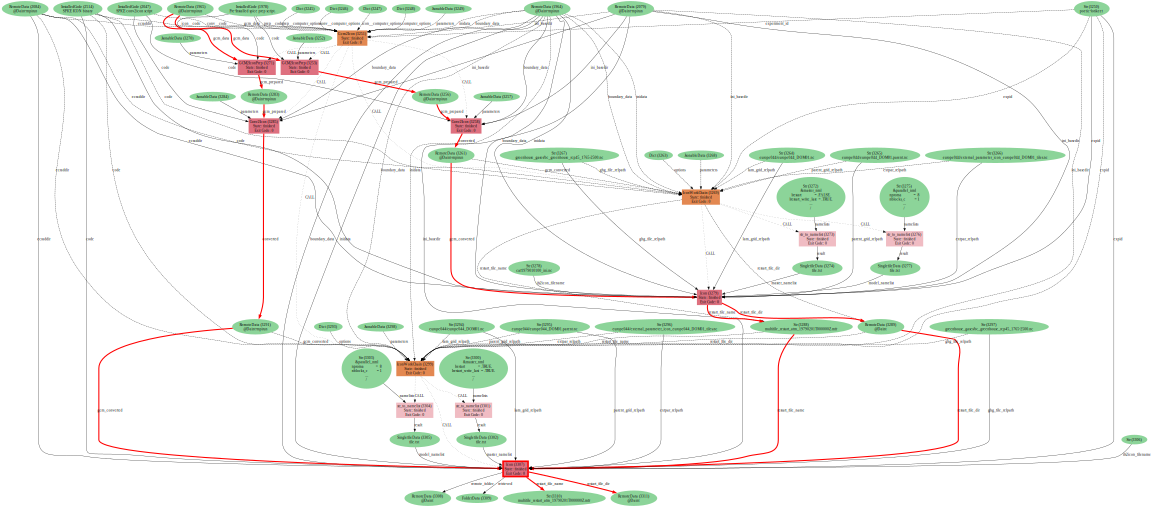

In [28]:
spice_graph = full_graph(3307, annotate_links="label")
# store_graph(spice_graph, GRAPHDIR, "simple_spice_graph")
spice_graph.graphviz

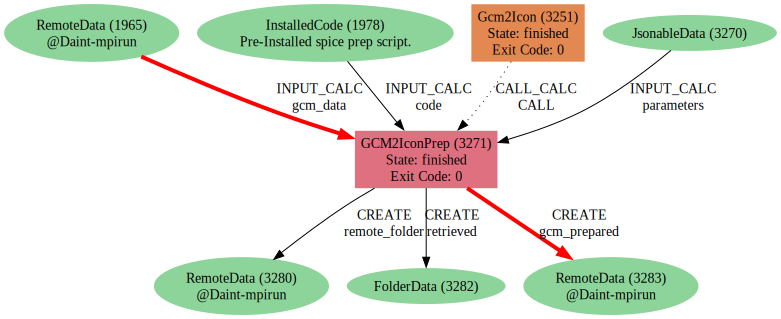

In [29]:
prep_graph = local_graph(3271, annotate_links="both")
# store_graph(prep_graph, GRAPHDIR, "prep_graph")
prep_graph.graphviz

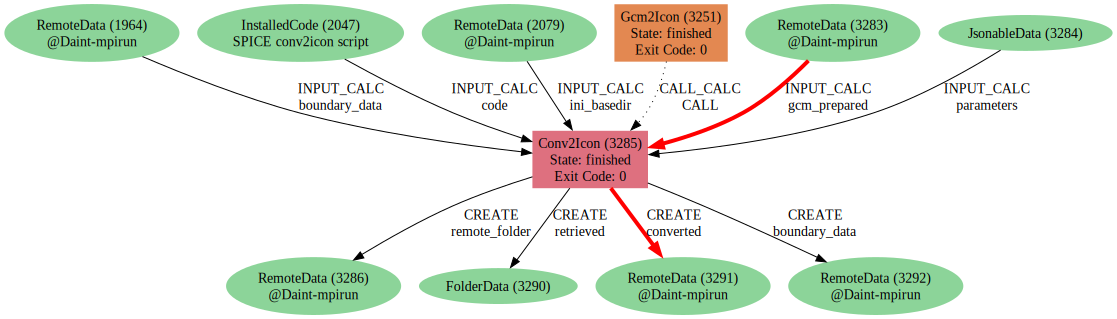

In [30]:
conv_graph = local_graph(3285, annotate_links="both")
#store_graph(conv_graph, GRAPHDIR, "conv_graph")
conv_graph.graphviz

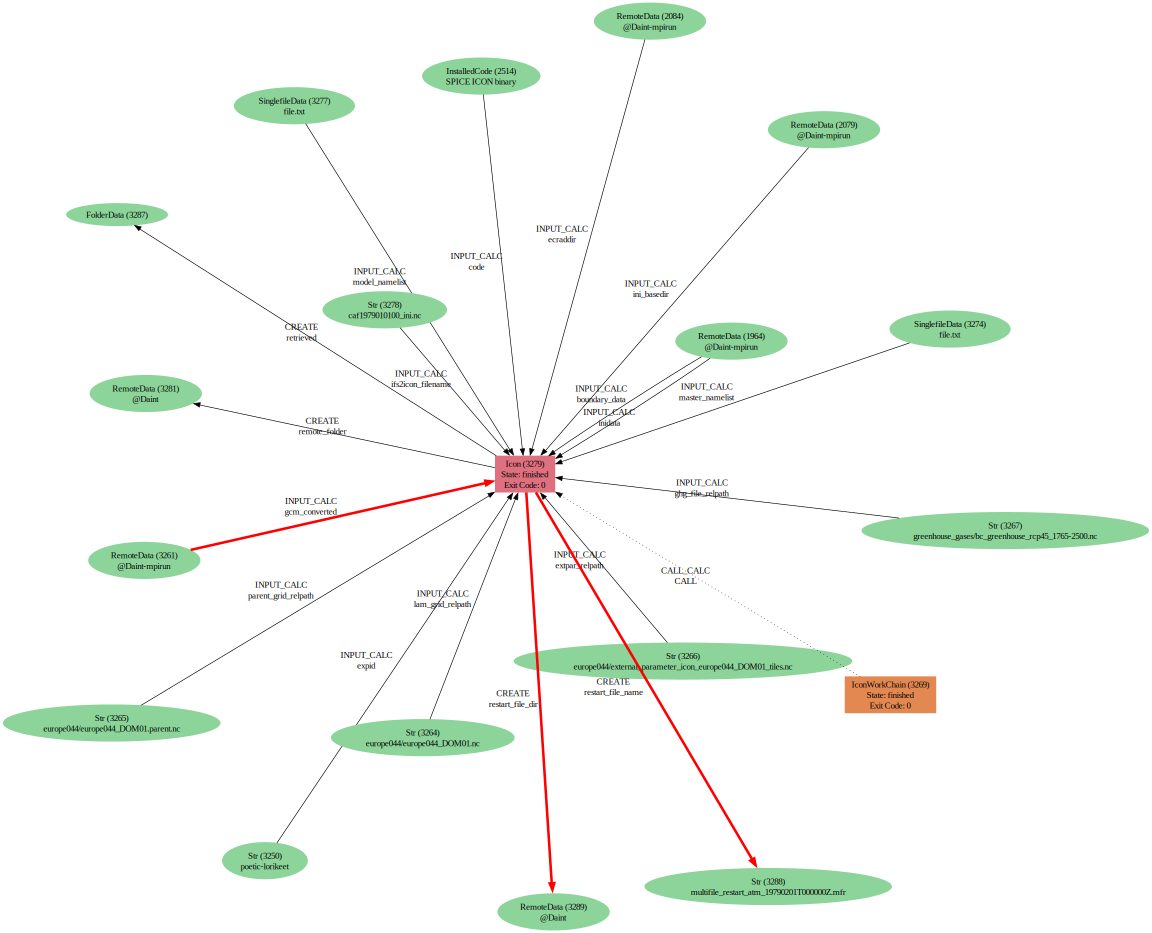

In [35]:
icon_graph = local_graph(3279, annotate_links="both", engine="sfdp")
#store_graph(icon_graph, GRAPHDIR, "icon_graph")
icon_graph.graphviz

In [32]:
full_graph(3690, annotate_links="label").graphviz.view()

'Digraph.gv.pdf'

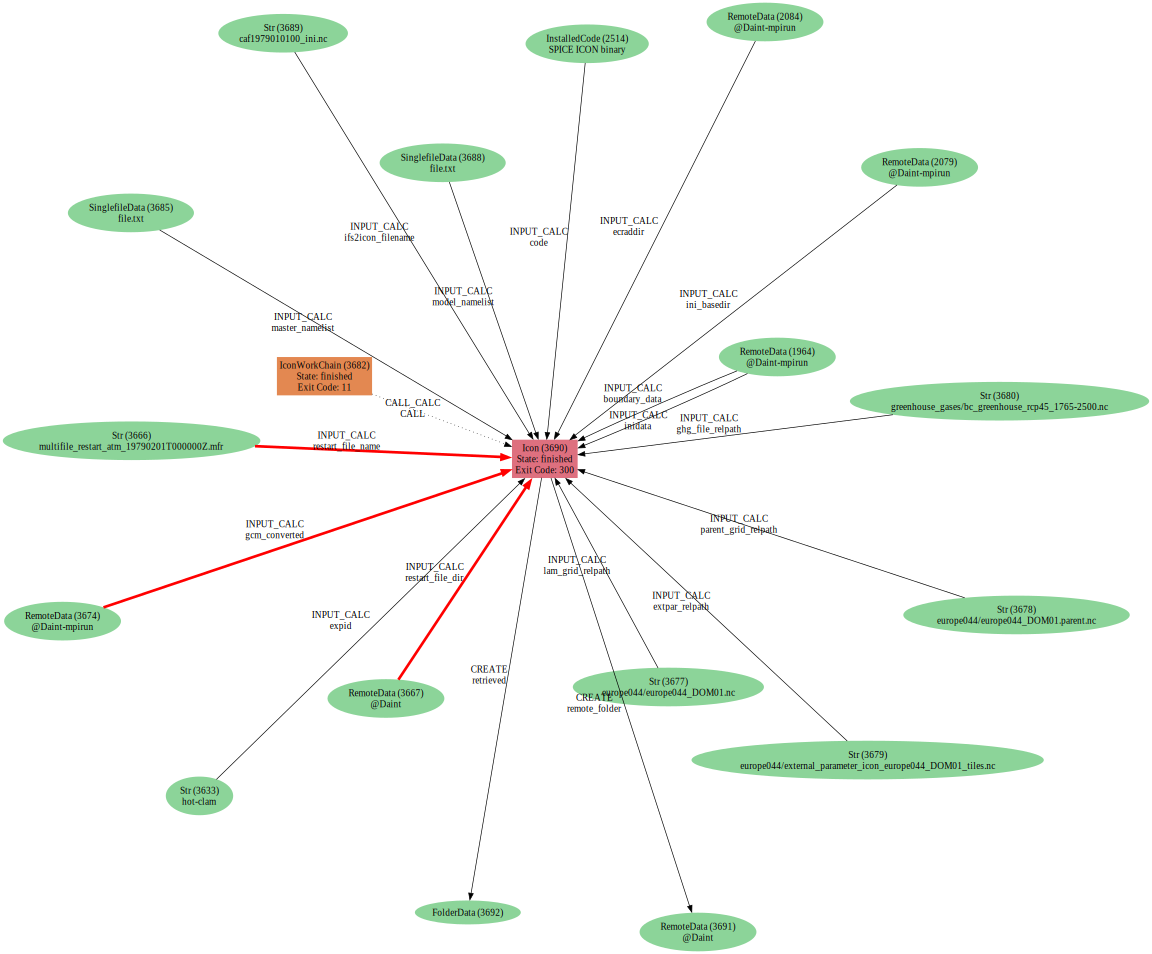

In [36]:
local_graph(3690, annotate_links="both", engine="sfdp").graphviz

In [246]:
common.LinkType?

Init signature:
common.LinkType(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
)
Docstring:      A simple enum of allowed link types.
File:           ~/.virtualenvs/aiida-c2sm/lib/python3.10/site-packages/aiida/common/links.py
Type:           EnumMeta
Subclasses:     